In [1]:
import os
import sys
import wandb

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import torch
torch.cuda.empty_cache()

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import transformers
from transformers import BertModel, BertForMaskedLM, BertConfig, BertTokenizerFast, get_linear_schedule_with_warmup, AdamW

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from typing import Sequence
from functools import partial
from collections import Counter

print(torch.__version__)
print(transformers.__version__)
print(torch.cuda.is_available())

1.10.1+cu113
4.23.1
True


## Split Data

In [2]:
dict_item_to_artist = pd.read_csv('../input/likes/track_artists.csv')
print(dict_item_to_artist['artistId'].nunique())
dict_item_to_artist = dict(zip(dict_item_to_artist['trackId'], dict_item_to_artist['artistId']))

56134


In [3]:
np.asarray(list(dict_item_to_artist.values())).max()

56133

In [4]:
like_history = []
train_items = set()

with open('../input/likes/train') as f:
    lines = f.readlines()
    for line in tqdm(lines):
        tracks = line.strip().split(' ')
        tracks = list(map(int, tracks))
        like_history.append(tracks)
        train_items.update(tracks)
like_history_lengths = np.asarray([len(x) for x in like_history])
bin_thresholds = np.quantile(like_history_lengths, q=[np.arange(0.1, 1.0, 0.1)])
like_history_bins = np.digitize(like_history_lengths, bins=bin_thresholds.flatten())

100%|██████████| 1160084/1160084 [00:16<00:00, 71742.00it/s]


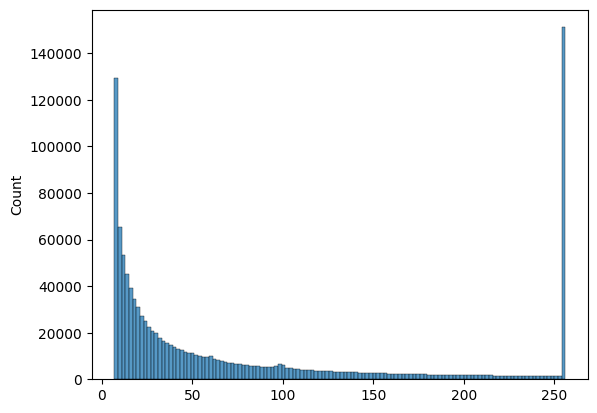

In [5]:
sns.histplot(like_history_lengths)
plt.show()

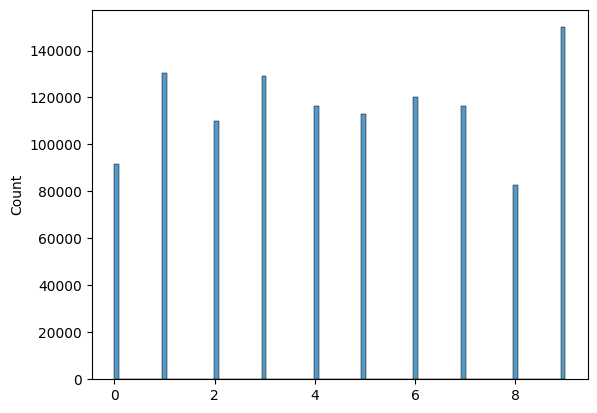

In [6]:
sns.histplot(like_history_bins)
plt.show()

In [7]:
like_history_bins

array([5, 1, 3, ..., 4, 5, 9])

In [8]:
train_like_history, val_like_history = train_test_split(like_history, test_size=0.2, random_state=9000, stratify=like_history_bins)

In [9]:
len(train_like_history), len(val_like_history)

(928067, 232017)

In [10]:
train_like_history_lengths = np.asarray([len(x) for x in train_like_history])
train_bin_thresholds = np.quantile(train_like_history_lengths, q=[np.arange(0.1, 1.0, 0.1)])
train_like_history_bins = np.digitize(train_like_history_lengths, bins=train_bin_thresholds.flatten())

val_like_history_lengths = np.asarray([len(x) for x in val_like_history])
val_bin_thresholds = np.quantile(val_like_history_lengths, q=[np.arange(0.1, 1.0, 0.1)])
val_like_history_bins = np.digitize(val_like_history_lengths, bins=val_bin_thresholds.flatten())

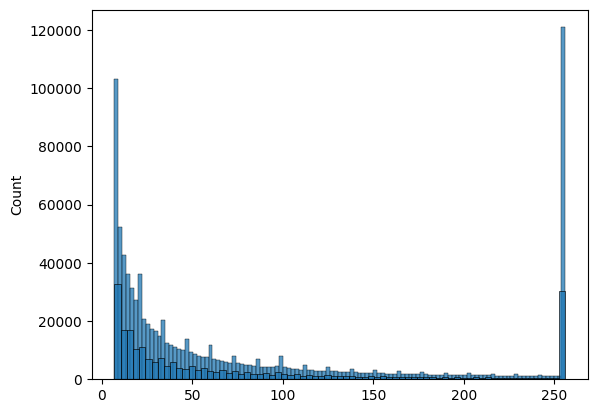

In [11]:
sns.histplot(train_like_history_lengths)
sns.histplot(val_like_history_lengths)
plt.show()

In [12]:
val_bin_thresholds

array([[  9.,  13.,  18.,  27.,  40.,  60.,  96., 160., 256.]])

In [13]:
len(val_like_history)

232017

In [14]:
class ItemEncoder:
    def __init__(self, keep_top_n):
        self.keep_top_n = keep_top_n
        self.item_to_id = None
        self.id_to_item = None
        self.counter = Counter()
        self.is_locked = False
        
    def fit(self, data):
        if self.is_locked:
            raise Exception("encoder has been locked")
        self.counter.update(data)
        
    def transform(self, data):
        if not self.is_locked:
            raise Exception("transforming with unlocked encoder is not allowed")
        return np.vectorize(lambda x: self.item_to_id.get(x, 0))(data) # unk key is 0
    
    def inverse_transform(self, data):
        if not self.is_locked:
            raise Exception("transforming with unlocked encoder is not allowed")
        return np.vectorize(self.id_to_item.__getitem__)(data)
    
    def lock(self):
        self.id_to_item = [-1] + list(map(lambda x: x[0], self.counter.most_common(self.keep_top_n)))
        self.item_to_id = {x: i for i, x in enumerate(self.id_to_item)}
        assert len(self.id_to_item) == len(self.item_to_id)
        self.is_locked = True
    
    def __len__(self):
        return len(self.id_to_item)
        
        

In [15]:
item_encoder = ItemEncoder(keep_top_n=None)
for seq in train_like_history:
    item_encoder.fit(seq)
item_encoder.lock()

In [16]:
artist_encoder = ItemEncoder(keep_top_n=None)
for seq in train_like_history:
    artist_encoder.fit(map(lambda x: dict_item_to_artist[x], seq))
artist_encoder.lock()

In [20]:
len(item_encoder)

483274

In [21]:
len(train_items)

483275

In [22]:
# affects only 5 users, skipping...
# val_like_history = [seq for seq in val_like_history if set(seq).issubset(train_items)]

In [23]:
len(val_like_history)

232017

In [24]:
item_encoder.counter.most_common(10)

[(286594, 45725),
 (99446, 44338),
 (39591, 43196),
 (422919, 41312),
 (70782, 41076),
 (8948, 40418),
 (244723, 39342),
 (19156, 37402),
 (79304, 36653),
 (244036, 36165)]

In [25]:
val_true = []
most_common_item = item_encoder.counter.most_common(1)[0][0]
for i, _ in tqdm(enumerate(val_like_history)):
    answer = val_like_history[i][-1]
    val_true += [answer]
    val_like_history[i][-1] = most_common_item # magic number for sanity check 

232017it [00:00, 1724764.07it/s]


In [26]:
val_like_history[0], val_true[0]

([44631,
  220326,
  469176,
  410,
  56743,
  284656,
  405041,
  248081,
  177932,
  151867,
  332108,
  335464,
  282124,
  480511,
  120369,
  471138,
  119719,
  150747,
  38338,
  287225,
  140597,
  370555,
  206811,
  198750,
  393462,
  114832,
  286594],
 59090)

## Create dataset

In [28]:
class SpecialTokens:
    def __init__(self, tokens):
        assert len(tokens) == len(set(tokens))
        assert 'pad_token' in tokens
        assert 'mask_token' in tokens
        self.n_tokens = len(tokens)
        for i, x in enumerate(tokens):
            setattr(self, x, i)
    
    def __len__(self):
        return self.n_tokens

In [29]:
def list2d_to_np(list2d, pad_token=-1):
    np_list2d = np.ones([len(list2d),len(max(list2d,key = lambda x: len(x)))], dtype=int) * pad_token
    for i,j in enumerate(list2d):
        np_list2d[i][0:len(j)] = j
    return np_list2d

In [30]:
class YaCupDataset(Dataset):
    def __init__(self,
                 data,
                 item_encoder,
                 artist_encoder,
                 item_to_artist_dict,
                 special_tokens: Sequence[str],
                 mask_prob: float,
                 force_last_token_mask_prob: float,
                 max_len: int):
        self.special_tokens = SpecialTokens(special_tokens)
        self.vocab_size = len(item_encoder) + len(self.special_tokens)
        self.artist_size = len(artist_encoder) + 1 # 0 is masked artist
        self.mask_prob = mask_prob
        self.force_last_token_mask_prob = force_last_token_mask_prob
        self.max_len = max_len
        self.item_encoder = item_encoder
        self.artist_encoder = artist_encoder
        self.item_to_artist_dict = item_to_artist_dict
        self.data, self.data_lengths, self.data_artists = YaCupDataset._preprocess_list_2d(
            data,
            token_shift=len(self.special_tokens),
            pad_token=self.special_tokens.pad_token,
            item_encoder=self.item_encoder,
            artist_encoder=self.artist_encoder,
            item_to_artist_dict = self.item_to_artist_dict,
            artist_shift = 1, # masked tokens are special 
        )
        
    def __getitem__(self, index):
        return self._preprocess_sequence(self.data[index], self.data_lengths[index], self.data_artists[index])

    def __len__(self):
        return len(self.data)
        
    @staticmethod
    def _preprocess_list_2d(list2d, token_shift, pad_token, item_encoder, artist_encoder, item_to_artist_dict, artist_shift):
        np_list2d = np.ones([len(list2d),len(max(list2d,key = lambda x: len(x)))], dtype=int) * pad_token
        np_lengths = np.zeros(len(list2d), dtype=int)
        np_list2d_artists = np.zeros([len(list2d),len(max(list2d,key = lambda x: len(x)))], dtype=int)
        for i,j in enumerate(list2d):
            np_list2d[i][0:len(j)] = item_encoder.transform(j)[::-1] # reverse for better pos encoding learning
            np_list2d[i][0:len(j)] += token_shift
            np_lengths[i] = len(j)
            # transform items to artists, encode artists with artist_encoder, reverse the order just like above
            np_list2d_artists[i][0:len(j)] = artist_encoder.transform(list(map(lambda x: item_to_artist_dict[x], j)))[::-1]
            np_list2d_artists[i][0:len(j)] += artist_shift
        return np_list2d, np_lengths, np_list2d_artists
    
    def _preprocess_sequence(self, sequence_ids, length, artist_ids):
        input_ids = torch.LongTensor(sequence_ids).clone()
        labels = torch.LongTensor(sequence_ids).clone()
            
        if np.random.random() < self.force_last_token_mask_prob:
            mask = torch.zeros(sequence_ids.shape)
            mask[0] = True
        else:
            mask = torch.rand(sequence_ids.shape)
            mask = (mask < self.mask_prob)
        mask *= (input_ids > len(self.special_tokens)) # don't mask special tokens
        if mask.sum() == 0:
            mask = torch.zeros(sequence_ids.shape)
            mask[0] = True
            mask *= (input_ids > len(self.special_tokens)) # don't mask special tokens
        mask_indices = mask.nonzero().flatten()
        n_masked = torch.LongTensor([len(mask_indices)])
        input_ids[mask_indices] = self.special_tokens.mask_token
        attention_mask = (input_ids != self.special_tokens.pad_token) * 1.0
        token_type_ids = torch.LongTensor(artist_ids).clone()
        token_type_ids[mask_indices] = 0 # masked segment
        artist_labels = torch.LongTensor(artist_ids).clone()
        
        artist_labels[token_type_ids != 0] = -100 # calculate loss only for masked tokens
        artist_labels[length:] = -100 # remove pad tokens from loss
        labels[input_ids != self.special_tokens.mask_token] = -100 # calculate loss only for masked tokens
#         labels[input_ids == self.special_tokens.pad_token] = -100 # calculate loss only for non-pad tokens
        inputs = {'input_ids': input_ids,
                  'token_type_ids': token_type_ids,
                  'attention_mask': attention_mask,
                  'labels': labels,
                  'artist_labels': artist_labels,
                  'n_masked': n_masked,
                  'last_token_index': torch.LongTensor([length - 1])}
        
        return inputs
        

In [31]:
DEVICE = 'cuda'

In [32]:
dataset = YaCupDataset(
    train_like_history,
    item_encoder=item_encoder,
    artist_encoder=artist_encoder,
    item_to_artist_dict=dict_item_to_artist,
    special_tokens=['cls_token', 'sep_token', 'mask_token', 'pad_token'],
    mask_prob=0.2,
    force_last_token_mask_prob=0.0,
    max_len=256
    )
val_dataset = YaCupDataset(
    val_like_history,
    item_encoder=item_encoder,
    artist_encoder=artist_encoder,
    item_to_artist_dict=dict_item_to_artist,
    special_tokens=['cls_token', 'sep_token', 'mask_token', 'pad_token'],
    mask_prob=0.2,
    force_last_token_mask_prob=1.0,
    max_len=256
    )

In [33]:
dataset[0]

{'input_ids': tensor([76419, 15434, 19046, 23232,     2,  6426, 34886, 12868,  4365,    56,
            61,  1734,  4771,  3188,   932,  2694, 16088, 16683,     2,   975,
             2,  1015,    16,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,   

In [34]:
val_dataset[0]

{'input_ids': tensor([    2,   238, 14495,  1724,   471, 12779,  6340, 14309,  4201,  3695,
          9704, 34980,  3540,   354,  2324,  1976,  3501,  9104,  3571,   236,
            31,   548,  1055,   225,   556,   382,  1508,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,   

In [36]:
# # +1 is a shift for a masked_artist token
# dict_item_to_artist_nn = {item_encoder.transform(k).tolist() + len(dataset.special_tokens) :artist_encoder.transform(v).tolist() + 1 for k, v in tqdm(dict_item_to_artist.items())}
# # 1 is an unknown artist token
# item_to_artist_indices_nn = torch.LongTensor(list(dict_item_to_artist_nn.get(item_id, 1) for item_id in range(dataset.vocab_size)))

In [37]:
dataloader = DataLoader(dataset,
                        batch_size=16,
                        num_workers=4,
                        drop_last=True,
                        shuffle=True,
                        pin_memory=True)
val_dataloader = DataLoader(val_dataset,
                            batch_size=16,
                            num_workers=4,
                            drop_last=False,
                            shuffle=False,
                            pin_memory=True)

In [41]:
from typing import List, Optional, Tuple, Union
from transformers.modeling_outputs import MaskedLMOutput
from torch.nn import CrossEntropyLoss


class YacupModel(nn.Module):
    def __init__(self, config, label_smoothing):
        super().__init__()
        self.config = config
        self.bert = BertModel(config, add_pooling_layer=False)
        self.bias = nn.Parameter(torch.zeros(config.vocab_size))
        
        self.label_smoothing = label_smoothing
        
    def init_weights(self):
        self.bert.init_weights()
                
    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        filter_history_items: Optional[bool] = False,
        loss_class_weight: Optional[torch.Tensor] = None,
        trim_length: Optional[int] = None,
        item_to_artist_mapper: Optional[torch.Tensor] = None,
    ) -> Union[Tuple[torch.Tensor], MaskedLMOutput]:
        """Mostly from https://github.com/huggingface/transformers/blob/v4.23.1/src/transformers/models/bert/modeling_bert.py#L1288"""
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        trim_length = trim_length if trim_length is not None else self.config.max_position_embeddings
        
        if item_to_artist_mapper is None:
            raise Exception("item_to_artist_mapper must be passed")
        
        outputs = self.bert(
            input_ids[:, :trim_length],
            attention_mask=attention_mask[:, :trim_length],
            token_type_ids=token_type_ids[:, :trim_length],
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]
        # sum of item and artist embeddings
        output_embedding_matrix = self.bert.embeddings.word_embeddings.weight + self.bert.embeddings.token_type_embeddings.weight[item_to_artist_mapper] # torch.index_select(self.bert.embeddings.token_type_embeddings.weight, dim=0, index=item_to_artist_mapper)
        prediction_scores = (sequence_output @ output_embedding_matrix.T) + self.bias
        if filter_history_items:
            prediction_scores.scatter_(dim=2, index=input_ids.unsqueeze(1), src=-10000 * torch.ones_like(input_ids.unsqueeze(1),dtype=prediction_scores.dtype))
        masked_lm_loss = None
        if labels is not None:
            # for some reason CrossEntropyLoss raises out of bounds exception when executed with `reduction = 'mean'` (default) when `label_smoothing != 0` and `weight is not None`
            # hence, to dodge this issue we init CrossEntropyLoss with `reduction='none'` and later we average the numbers
            if self.label_smoothing != 0.0:
                loss_fct = CrossEntropyLoss(weight=loss_class_weight, label_smoothing=self.label_smoothing, reduction='none')
                masked_lm_loss = loss_fct(prediction_scores.view(-1, self.config.vocab_size), labels[:, :trim_length].flatten()).sum()
            else:
                loss_fct = CrossEntropyLoss(weight=loss_class_weight, label_smoothing=self.label_smoothing, reduction='sum')
                masked_lm_loss = loss_fct(prediction_scores.view(-1, self.config.vocab_size), labels[:, :trim_length].flatten())

        if not return_dict:
            output = (prediction_scores,) + outputs[2:]
            return ((masked_lm_loss,) + output) if masked_lm_loss is not None else output

        return MaskedLMOutput(
            loss=masked_lm_loss,
            logits=prediction_scores,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

            

In [42]:
model_config = BertConfig(
    vocab_size=dataset.vocab_size,
    hidden_size=448,
    max_position_embeddings=256,
    attention_probs_dropout_prob=0.0,
    hidden_act='gelu',
    hidden_dropout_prob=0.0,
    initializer_range=0.02,
    intermediate_size=1024,
    num_attention_heads=4,
    num_hidden_layers=2,
    type_vocab_size=dataset.artist_size
)

model = YacupModel(
    model_config,
    label_smoothing=0.0)
model.init_weights()

In [45]:
model

YacupModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(483278, 448, padding_idx=0)
      (position_embeddings): Embedding(256, 448)
      (token_type_embeddings): Embedding(56136, 448)
      (LayerNorm): LayerNorm((448,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=448, out_features=448, bias=True)
              (key): Linear(in_features=448, out_features=448, bias=True)
              (value): Linear(in_features=448, out_features=448, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=448, out_features=448, bias=True)
              (LayerNorm): LayerNorm((448,), eps=1e-12, elementwise_affine=Tr

In [47]:
def calc_mrr(predict, answer):
    for i in range(len(predict)):
        if predict[i] == answer:
            return 1. / (i + 1)
    return 0

max_prediction_len = 100

def calc_score(y_true, y_pred):
    mrr_score = 0
    for (pred, answer) in tqdm(zip(y_pred, y_true)):
        if len(pred) > max_prediction_len:
            raise ValueError('$maximum prediction length is {}, got {}$'.format(max_prediction_len, len(y_pred[i])))
        mrr_score += calc_mrr(pred, answer)

    print("MRR@100 = {}".format(mrr_score / len(y_true)))
    return mrr_score / len(y_true)

In [48]:
# crutch: put loops in scope to avoid memory fragmentaion

def train(model, dl, DEVICE, TRIM_LENGTH):
    item_to_artist_indices_nn = torch.LongTensor(list(dict_item_to_artist_nn.get(item_id, 1) for item_id in range(dataset.vocab_size))).to(DEVICE, non_blocking=True)
    loss_class_weight = torch.ones(dataset.vocab_size)
    loss_class_weight[:len(dataset.special_tokens) + 1] = 0.0 # we don't care about a special token loss or an unk token loss
    loss_class_weight = loss_class_weight.to(DEVICE, non_blocking=True)

    tbar = tqdm(dl, file=sys.stdout)
    loss_sum = 0.0
    n_masked_sum = 0
    model.train()
    for idx, batch in enumerate(tbar):
        with torch.cuda.amp.autocast():
            res = model.forward(input_ids=batch['input_ids'].to(DEVICE, non_blocking=True),
                              attention_mask=batch['attention_mask'].to(DEVICE, non_blocking=True),
                              token_type_ids=batch['token_type_ids'].to(DEVICE, non_blocking=True),
                              labels=batch['labels'].to(DEVICE, non_blocking=True),
                              filter_history_items=True,
                              loss_class_weight=loss_class_weight,
                              trim_length=TRIM_LENGTH,
                              item_to_artist_mapper=item_to_artist_indices_nn)
            batch_masked_sum = batch['n_masked'].to(DEVICE, non_blocking=True).sum()
            loss = res.loss # / batch_masked_sum; normalization hurts performance
        scaler.scale(loss).backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)

        if (idx + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()
            
        loss_sum += res.loss.detach().item()
        n_masked_sum += batch_masked_sum.detach().item()
        tbar.set_postfix_str(f"Epoch {e + 1} Loss: {loss_sum / n_masked_sum} lr: {optimizer.param_groups[0]['lr']:.5}")
        
        if idx % 100 == 0:
            wandb.log({"loss": loss_sum / n_masked_sum})

@torch.no_grad()            
def validate(model, dl, DEVICE, TRIM_LENGTH):
    item_to_artist_indices_nn = torch.LongTensor(list(dict_item_to_artist_nn.get(item_id, 1) for item_id in range(dataset.vocab_size))).to(DEVICE, non_blocking=True)
    
    model.eval()
    all_preds = []
    for batch in tqdm(dl):
        with torch.no_grad():
            with torch.cuda.amp.autocast():
                batch_input_ids = batch['input_ids'].to(DEVICE, non_blocking=True)
                res = model.forward(input_ids=batch_input_ids,
                              attention_mask=batch['attention_mask'].to(DEVICE, non_blocking=True),
                              token_type_ids=batch['token_type_ids'].to(DEVICE, non_blocking=True),
                              labels=batch['labels'].to(DEVICE, non_blocking=True),
                              filter_history_items=True,
                              trim_length=TRIM_LENGTH,
                              item_to_artist_mapper=item_to_artist_indices_nn)

                scores = res.logits[:, 0, :].unsqueeze(1) # predict last item
                scores[:, :, :len(dataset.special_tokens) + 1] = -10000 # +1 due to unk token
                 # remove historical items form predictions; allow only new items
                scores.scatter_(dim=2, index=batch_input_ids.unsqueeze(1), src=-10000 * torch.ones_like(batch_input_ids.unsqueeze(1),dtype=scores.dtype))
                scores = scores.squeeze(1)
                preds = torch.topk(scores, k=100, dim=1).indices - len(dataset.special_tokens)
                all_preds += preds.detach().cpu().numpy().tolist()

    all_preds = item_encoder.inverse_transform(all_preds)
    return all_preds
    

In [49]:
@torch.no_grad()
def load_from_checkpoint(checkpoint_name, model, optimizer, new_lr=None):
    checkpoint = torch.load(checkpoint_name)
    model.load_state_dict(checkpoint['model'])
    if new_lr is not None:
        for param_groups in checkpoint['optimizer']['param_groups']:
            param_groups['lr'] = new_lr
            param_groups['initial_lr'] = new_lr
    optimizer.load_state_dict(checkpoint['optimizer'])

In [50]:
@torch.no_grad()
def clone_positional_embeddings(model, id_from, ids_to, add):
    for idx in ids_to:
        if add:
            model.bert.embeddings.position_embeddings.weight[idx] = model.bert.embeddings.position_embeddings.weight[idx] + model.bert.embeddings.position_embeddings.weight[id_from].clone()
        else:
            model.bert.embeddings.position_embeddings.weight[idx] = model.bert.embeddings.position_embeddings.weight[id_from].clone()

In [51]:
DEVICE = 'cuda'
model.to(DEVICE)
TRIM_LENGTH = 128
best_val_score = -10000.0

checkpoint_name = 'output/checkpoint_ne1l6afj_5.pth'

# +1 is a shift for masked_artist token
dict_item_to_artist_nn = {item_encoder.transform(k).tolist() + len(dataset.special_tokens) :artist_encoder.transform(v).tolist() + 1 for k, v in tqdm(dict_item_to_artist.items())}
# # 1 is an unknown artist token
# item_to_artist_indices_nn = torch.LongTensor(list(dict_item_to_artist_nn.get(item_id, 1) for item_id in range(dataset.vocab_size))).to(DEVICE)


epochs=7
accumulation_steps=100
learning_rate = 5.25e-5
num_train_optimization_steps = int(epochs * len(dataloader) / accumulation_steps)
correct_bias = True
weight_decay = 1e-05
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
param_optimizer = list(model.named_parameters())
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate,
                      correct_bias=correct_bias, )

if checkpoint_name is not None:
    load_from_checkpoint(checkpoint_name, model, optimizer, new_lr=learning_rate)
#     clone_positional_embeddings(model, id_from=63, ids_to=np.arange(64, 256), add=False)

warmup_steps = int(0 * len(dataloader) / accumulation_steps)

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                                num_training_steps=num_train_optimization_steps)
scaler = torch.cuda.amp.GradScaler()
run = wandb.init(project='YaCup2022', config=model_config.to_diff_dict())
run.config.update({
    'n_whitelisted_items': item_encoder.keep_top_n,
    'mask_prob': dataset.mask_prob,
    'force_last_token_mask_prob': dataset.force_last_token_mask_prob,
    'batch_size': dataloader.batch_size,
    'epochs': epochs,
    'accumulation_steps': accumulation_steps,
    'learning_rate': learning_rate,
    'warmup_steps': warmup_steps,
    'num_train_optimization_steps': num_train_optimization_steps,
    'correct_bias': correct_bias,
    'label_smoothing': model.label_smoothing,
    'weight_decay': weight_decay,
    'from_checkpoint': checkpoint_name,
})

for e in range(epochs):
    torch.cuda.empty_cache()
    train(model,
          dataloader,
          DEVICE=DEVICE,
          TRIM_LENGTH=TRIM_LENGTH)
            
    all_preds = validate(model,
                         val_dataloader,
                         DEVICE=DEVICE,
                         TRIM_LENGTH=TRIM_LENGTH)
    
    checkpoint = { 
        'epoch': e,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(checkpoint, f'output/checkpoint_{run.id}_{e}.pth')

    score = calc_score(val_true[:len(all_preds)], all_preds)
    if score > best_val_score:
        best_val_score = score
        torch.save(model.state_dict(), f'output/model_{run.id}.pt')
    wandb.log({"score": score})

run.finish()

100%|██████████| 483275/483275 [00:06<00:00, 75811.72it/s]
/home/maximtsygankov/anaconda3/envs/yacup_2022_env/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
wandb: Currently logged in as: maximtsygankov. Use `wandb login --relogin` to force relogin


  0%|          | 101/58004 [00:14<2:18:28,  6.97it/s, Epoch 1 Loss: 5.188444602723854 lr: 5.2487e-05]

/home/maximtsygankov/anaconda3/envs/yacup_2022_env/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


100%|██████████| 58004/58004 [2:19:44<00:00,  6.92it/s, Epoch 1 Loss: 5.2341794445952265 lr: 4.5e-05]     


100%|██████████| 14502/14502 [14:01<00:00, 17.24it/s]
232017it [00:02, 97617.27it/s]


MRR@100 = 0.07951968593546217
  0%|          | 127/58004 [00:19<2:26:03,  6.60it/s, Epoch 2 Loss: 5.2069521148636895 lr: 4.4987e-05]


KeyboardInterrupt: 

In [53]:
np.savetxt(f'output/result_val_1dpq6fhg_0.txt', all_preds, fmt='%d')

In [51]:
checkpoint = torch.load('output/checkpoint_1dpq6fhg_0.pth')

In [52]:
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [53]:
DEVICE = 'cuda'
model.to(DEVICE)
TRIM_LENGTH = 128

dict_item_to_artist_nn = {item_encoder.transform(k).tolist() + len(dataset.special_tokens) :artist_encoder.transform(v).tolist() + 1 for k, v in tqdm(dict_item_to_artist.items())}

test_like_history = []

with open('../input/likes/test') as f:
    lines = f.readlines()
    for line in tqdm(lines):
        tracks = line.strip().split(' ')
        tracks = list(map(int, tracks))
        tracks.append(most_common_item) # an item that will be masked
        test_like_history.append(tracks)

test_dataset = YaCupDataset(
    test_like_history,
    item_encoder=item_encoder,
    artist_encoder=artist_encoder,
    item_to_artist_dict=dict_item_to_artist,
    special_tokens=['cls_token', 'sep_token', 'mask_token', 'pad_token'],
    mask_prob=0.2,
    force_last_token_mask_prob=1.0,
    max_len=256
    )

test_dataloader = DataLoader(test_dataset,
                            batch_size=16,
                            num_workers=4,
                            drop_last=False,
                            shuffle=False,
                            pin_memory=True)

all_preds = validate(model,
                     test_dataloader,
                     DEVICE=DEVICE,
                     TRIM_LENGTH=TRIM_LENGTH)
np.savetxt(f'output/result_1dpq6fhg_0.txt', all_preds, fmt='%d')

100%|██████████| 18120/18120 [17:29<00:00, 17.27it/s] 
